In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv(r'/workspaces/miniconda/PKdata/data-raw/KI20160914/KI20160914.csv')

In [3]:
d1_df = df.loc[df['DAY'] == 1, :]

In [4]:
def plot_subject_levels(df:pd.DataFrame,x = 'TIME' ,y = 'DV', subject = 'SUBJID', ax = None):
    if ax is None:
        fig, ax = plt.subplots(1)
    for c in df.columns:
        df.loc[df[c] == '.', c] = pd.NA
    df[y] = df[y].astype(pd.Float32Dtype())
    df[x] = df[x].astype(pd.Float32Dtype())
    sns.lineplot(data = df, x = 'TIME', y = 'DV', hue = 'SUBJID', ax = ax)
        

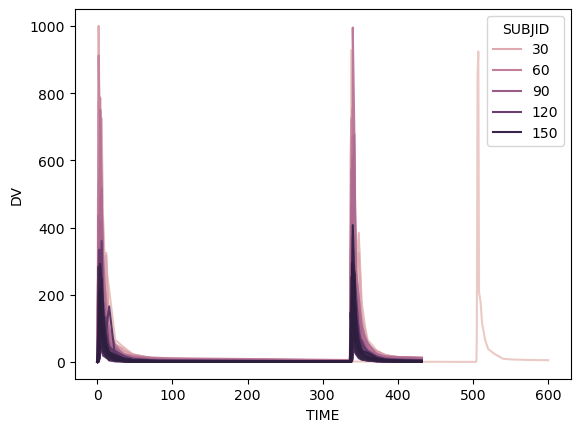

In [5]:
plot_subject_levels(df)

In [18]:
from scipy.integrate import solve_ivp
import numpy as np
from tqdm import tqdm
import_funcs = False
if import_funcs:
    def one_compartment_model(t, y, k, Vd, dose):
        """
        Defines the differential equation for a one-compartment pharmacokinetic model.

        This function calculates the rate of change of drug concentration in the central 
        compartment over time.

        Args:
        t (float): Time point (not used in this specific model, but required by solve_ivp).
        y (list): Current drug concentration in the central compartment.
        k (float): Elimination rate constant.
        Vd (float): Volume of distribution.
        dose (float): Administered drug dose (not used in this model, as it assumes 
                        intravenous bolus administration where the initial concentration 
                        is directly given).

        Returns:
        float: The rate of change of drug concentration (dC/dt).
        """
        C = y[0]  # Extract concentration from the state vector
        dCdt = -(k/Vd) * C  # Calculate the rate of change
        return dCdt

    def objective_function(params, data, subject_id = 'SUBJID', dose = 'DOSR', time = 'TIME', conc_at_time = 'DV'):
        """
        Calculates the sum of squared errors (SSE) between observed and predicted drug 
        concentrations.

        This function simulates drug concentrations for each subject in the dataset using 
        a one-compartment model and compares the predictions to the actual observations. 
        The SSE is used as a measure of the goodness of fit for the given model parameters.

        Args:
            params (tuple): Tuple containing the model parameters (k, Vd).
            data (DataFrame): Pandas DataFrame containing the pharmacokinetic data, with columns
                            for 'SUBJID', 'DOSR', 'DV' (observed concentration), and 'TIME'.

        Returns:
            float: The sum of squared errors (SSE).
        """
        k, Vd = params  # Unpack parameters
        #Vd = Vd + 1e-6 if Vd == 0 else Vd  # Add a small value to Vd to avoid division by zero (commented out)
        predictions = []
        for subject in tqdm(data[subject_id].unique()):  # Loop through each subject in the dataset
            d = data.loc[data[subject_id] == subject, dose]  # Extract dose information for the subject
            d = d.drop_duplicates()  # Ensure only one dose value is used
            dose = d.values[0]  # Get the dose value
            subject_data = data[data[subject_id] == subject]  # Get data for the current subject
            initial_conc = subject_data[conc_at_time].values[0]  # Get the initial concentration

            # Solve the differential equation for the current subject
            sol = solve_ivp(one_compartment_model, [subject_data[time].min(), subject_data[time].max()], [initial_conc], 
                            t_eval=subject_data[time], args=(k, Vd, dose))
            
            predictions.extend(sol.y[0])  # Add the predictions for this subject to the list

        residuals = data[conc_at_time] - predictions  # Calculate the difference between observed and predicted values
        sse = np.sum(residuals**2)  # Calculate the sum of squared errors
        return sse

In [19]:
opt_df = df.dropna(subset = 'DV').copy()
#opt_df = opt_df.loc[opt_df['DV'] > 0, :]
opt_df['DV'] = opt_df['DV'].astype(pd.Float32Dtype())
opt_df = opt_df.loc[opt_df['DAY'] == 1, :]

In [20]:
opt_df.groupby('SUBJID')['DV'].max()

SUBJID
1.0      275.0
2.0      625.0
3.0      498.0
4.0      302.0
5.0      632.0
         ...  
155.0    247.0
156.0    217.0
157.0    117.0
158.0    101.0
159.0    207.0
Name: DV, Length: 159, dtype: Float32

In [21]:
dfs = []
for c in opt_df['SUBJID'].drop_duplicates():
    work_df = opt_df.loc[opt_df['SUBJID'] == c, :].reset_index(drop = True)
    max_idx = work_df.loc[work_df['DV'] == work_df['DV'].max(), :].index[0]
    work_df = work_df.iloc[max_idx:, :]
    work_df['TIME'] = work_df['TIME'] - work_df['TIME'].min()
    dfs.append(work_df.copy())
work_df = pd.concat(dfs)

<Axes: xlabel='TIME', ylabel='DV'>

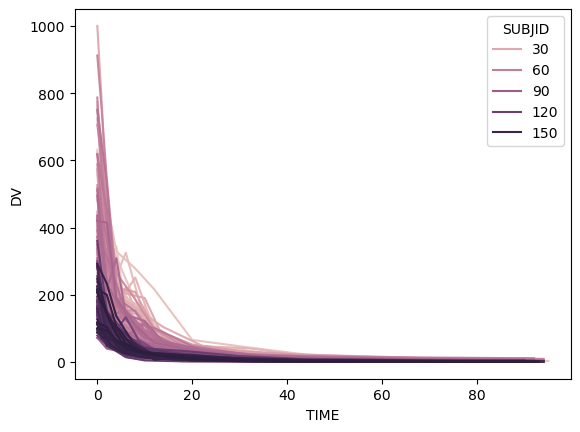

In [22]:
sns.lineplot(data = work_df, x = 'TIME', y = 'DV', hue = 'SUBJID')

In [23]:
work_df

,SUBJID,VIST,DAY,TIME,NTPD,DOSR,AMT,DV,FORM,TRTCD,SEX,AGE,WT
2,1.0,1.0,1.0,0.0,1.0,300.0,NaN,275.0,0.0,B,1.0,26.0,84.0
3,1.0,1.0,1.0,1.0,2.0,300.0,NaN,244.0,0.0,B,1.0,26.0,84.0
4,1.0,1.0,1.0,2.0,3.0,300.0,NaN,151.0,0.0,B,1.0,26.0,84.0
5,1.0,1.0,1.0,3.0,4.0,300.0,NaN,130.0,0.0,B,1.0,26.0,84.0
6,1.0,1.0,1.0,5.0,6.0,300.0,NaN,147.0,0.0,B,1.0,26.0,84.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10,159.0,1.0,1.0,21.0,24.0,100.0,NaN,7.91,1.0,B,1.0,33.0,95.0
11,159.0,1.0,1.0,33.0,36.0,100.0,NaN,3.02,1.0,B,1.0,33.0,95.0
12,159.0,1.0,1.0,45.0,48.0,100.0,NaN,1.7,1.0,B,1.0,33.0,95.0
13,159.0,1.0,1.0,69.0,72.0,100.0,NaN,1.42,1.0,B,1.0,33.0,95.0


In [24]:
import numpy as np
from scipy.optimize import minimize
from joblib import dump, load
import os
from functools import partial

def optimize_with_checkpoint_joblib(func, x0, n_checkpoint, checkpoint_filename, *args, **kwargs):
    """
    Optimizes a function using scipy.optimize.minimize() with checkpointing every n iterations,
    using joblib for saving and loading checkpoints.

    Args:
        func: The objective function to be minimized.
        x0: The initial guess.
        n_checkpoint: The number of iterations between checkpoints.
        checkpoint_filename: The filename to save checkpoints to.
        *args: Additional positional arguments to be passed to minimize().
        **kwargs: Additional keyword arguments to be passed to minimize().

    Returns:
        The optimization result from scipy.optimize.minimize().
    """

    iteration = 0
    
    # Try to load a previous checkpoint if it exists
    try:
        checkpoint = load(checkpoint_filename)
        x0 = checkpoint['x']
        iteration = checkpoint['iteration']
        print(f"Resuming optimization from iteration {iteration}")
    except FileNotFoundError:
        print("No checkpoint found, starting from initial guess.")
    except Exception as e:
        print(f"Error loading checkpoint: {e}, starting from initial guess.")

    def callback_with_checkpoint(xk, checkpoint_filename):
        nonlocal iteration
        iteration += 1
        print(iteration)
        if iteration % n_checkpoint == 0:
            checkpoint = {
                'x': xk,
                'iteration': iteration
            }
            checkpoint_filename = checkpoint_filename.replace('.jb', f'_{iteration}.jb')
            dump(checkpoint, checkpoint_filename)
            print(f"Iteration {iteration}: Checkpoint saved to {checkpoint_filename}")
        print('no log')

    # Ensure callback is not already in kwargs
    if 'callback' not in kwargs:
        kwargs['callback'] = partial(callback_with_checkpoint, checkpoint_filename = checkpoint_filename)
    else:
        # If callback exists, combine it with the existing one
        user_callback = kwargs['callback']
        def combined_callback(xk):
            callback_with_checkpoint(xk, checkpoint_filename)
            user_callback(xk)

        kwargs['callback'] = combined_callback
    
    result = minimize(func, x0, *args, **kwargs)
    
    # Remove checkpoint file at end.
    #try:
    #    os.remove(checkpoint_filename)
    #except:
    #    pass

    return result

In [25]:
work_df

,SUBJID,VIST,DAY,TIME,NTPD,DOSR,AMT,DV,FORM,TRTCD,SEX,AGE,WT
2,1.0,1.0,1.0,0.0,1.0,300.0,NaN,275.0,0.0,B,1.0,26.0,84.0
3,1.0,1.0,1.0,1.0,2.0,300.0,NaN,244.0,0.0,B,1.0,26.0,84.0
4,1.0,1.0,1.0,2.0,3.0,300.0,NaN,151.0,0.0,B,1.0,26.0,84.0
5,1.0,1.0,1.0,3.0,4.0,300.0,NaN,130.0,0.0,B,1.0,26.0,84.0
6,1.0,1.0,1.0,5.0,6.0,300.0,NaN,147.0,0.0,B,1.0,26.0,84.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10,159.0,1.0,1.0,21.0,24.0,100.0,NaN,7.91,1.0,B,1.0,33.0,95.0
11,159.0,1.0,1.0,33.0,36.0,100.0,NaN,3.02,1.0,B,1.0,33.0,95.0
12,159.0,1.0,1.0,45.0,48.0,100.0,NaN,1.7,1.0,B,1.0,33.0,95.0
13,159.0,1.0,1.0,69.0,72.0,100.0,NaN,1.42,1.0,B,1.0,33.0,95.0


In [26]:
from sklearn.preprocessing import RobustScaler
scale_df = work_df.copy()
scale_df[['DV']] = RobustScaler().fit_transform(scale_df[['DV']])
scale_df['DOSR'] = scale_df['DOSR'] / 100
scale_df

,SUBJID,VIST,DAY,TIME,NTPD,DOSR,AMT,DV,FORM,TRTCD,SEX,AGE,WT
2,1.0,1.0,1.0,0.0,1.0,3.0,NaN,2.477687,0.0,B,1.0,26.0,84.0
3,1.0,1.0,1.0,1.0,2.0,3.0,NaN,2.170270,0.0,B,1.0,26.0,84.0
4,1.0,1.0,1.0,2.0,3.0,3.0,NaN,1.248017,0.0,B,1.0,26.0,84.0
5,1.0,1.0,1.0,3.0,4.0,3.0,NaN,1.039766,0.0,B,1.0,26.0,84.0
6,1.0,1.0,1.0,5.0,6.0,3.0,NaN,1.208350,0.0,B,1.0,26.0,84.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10,159.0,1.0,1.0,21.0,24.0,1.0,NaN,-0.170964,1.0,B,1.0,33.0,95.0
11,159.0,1.0,1.0,33.0,36.0,1.0,NaN,-0.219457,1.0,B,1.0,33.0,95.0
12,159.0,1.0,1.0,45.0,48.0,1.0,NaN,-0.232547,1.0,B,1.0,33.0,95.0
13,159.0,1.0,1.0,69.0,72.0,1.0,NaN,-0.235323,1.0,B,1.0,33.0,95.0


In [27]:
scale_df['DOSR'].unique()

array([3., 1.])

In [28]:
from scipy.optimize import minimize


#opt_df = opt_df.loc[opt_df['TIME'] >= 1, :].copy()
initial_guess = [0.1, 4.0]  # Initial guesses for k and Vd
result = optimize_with_checkpoint_joblib(objective_function, initial_guess, n_checkpoint=1, checkpoint_filename='check.jb', args=(scale_df,), bounds=[(1e-6,None),(1e-6,None)]) #Bounds added to prevent negative values
#result = minimize(objective_function, initial_guess, args=(work_df,), bounds=[(1e-6,None),(1e-6,None)])

No checkpoint found, starting from initial guess.


100%|██████████| 159/159 [00:00<00:00, 296.52it/s]


1
Iteration 1: Checkpoint saved to check_1.jb
no log


100%|██████████| 159/159 [00:00<00:00, 319.65it/s]

2
Iteration 2: Checkpoint saved to check_2.jb
no log


In [29]:
result

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 176.6276104045588
        x: [ 1.100e+00  4.000e+00]
      nit: 2
      jac: [ 3.185e+01  2.269e+01]
     nfev: 39
     njev: 13
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>

In [30]:
result

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 176.6276104045588
        x: [ 1.100e+00  4.000e+00]
      nit: 2
      jac: [ 3.185e+01  2.269e+01]
     nfev: 39
     njev: 13
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>

In [31]:
opt_df

,SUBJID,VIST,DAY,TIME,NTPD,DOSR,AMT,DV,FORM,TRTCD,SEX,AGE,WT
1,1.0,1.0,1.0,0.25,0.25,300.0,<NA>,0.0,0.0,B,1.0,26.0,84.0
2,1.0,1.0,1.0,0.5,0.50,300.0,<NA>,35.299999,0.0,B,1.0,26.0,84.0
3,1.0,1.0,1.0,1.0,1.00,300.0,<NA>,275.0,0.0,B,1.0,26.0,84.0
4,1.0,1.0,1.0,2.0,2.00,300.0,<NA>,244.0,0.0,B,1.0,26.0,84.0
5,1.0,1.0,1.0,3.0,3.00,300.0,<NA>,151.0,0.0,B,1.0,26.0,84.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5199,159.0,1.0,1.0,24.0,24.00,100.0,<NA>,7.91,1.0,B,1.0,33.0,95.0
5200,159.0,1.0,1.0,36.0,36.00,100.0,<NA>,3.02,1.0,B,1.0,33.0,95.0
5201,159.0,1.0,1.0,48.0,48.00,100.0,<NA>,1.7,1.0,B,1.0,33.0,95.0
5202,159.0,1.0,1.0,72.0,72.00,100.0,<NA>,1.42,1.0,B,1.0,33.0,95.0


In [31]:
result

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 3088.2896666792676
        x: [ 1.000e-06  6.369e+03]
      nit: 25
      jac: [ 1.819e-04  0.000e+00]
     nfev: 81
     njev: 27
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>

In [ ]:
predictions = {}
est_k, est_vd = result.x
data = scale_df
for subject in data['SUBJID'].unique():
    d = data.loc[data['SUBJID'] == subject, 'DOSR']
    d =  d.drop_duplicates()
    dose = d.values[0]
    subject_data = data[data['SUBJID'] == subject]
    subject_data = data[data['SUBJID'] == subject]
    initial_conc = subject_data['DV'].values[0]
    #the initial value is initial_conc in this setup. If absorbtion was being modeled it would be [dose/est_vd]
    sol = solve_ivp(one_compartment_model, [subject_data['TIME'].min(), subject_data['TIME'].max()], [initial_conc],
                    t_eval=subject_data['TIME'], args=(est_k, est_vd, dose))
    predictions[subject] = sol

In [41]:
predictions[1]

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  1.000e+00 ...  7.100e+01  9.500e+01]
        y: [[ 2.478e+00  1.882e+00 ... -1.187e-08  2.345e-07]]
      sol: None
 t_events: None
 y_events: None
     nfev: 122
     njev: 0
      nlu: 0

In [42]:
predictions[1].y[0]

array([ 2.47768742e+00,  1.88196282e+00,  1.42915880e+00,  1.08503953e+00,
        6.26801782e-01,  3.61568671e-01,  1.20488611e-01,  4.01165258e-02,
        4.44913077e-03,  1.64444269e-04,  6.17945297e-06, -1.18739247e-08,
        2.34513666e-07])

In [43]:
scale_df

,SUBJID,VIST,DAY,TIME,NTPD,DOSR,AMT,DV,FORM,TRTCD,SEX,AGE,WT
2,1.0,1.0,1.0,0.0,1.0,3.0,NaN,2.477687,0.0,B,1.0,26.0,84.0
3,1.0,1.0,1.0,1.0,2.0,3.0,NaN,2.170270,0.0,B,1.0,26.0,84.0
4,1.0,1.0,1.0,2.0,3.0,3.0,NaN,1.248017,0.0,B,1.0,26.0,84.0
5,1.0,1.0,1.0,3.0,4.0,3.0,NaN,1.039766,0.0,B,1.0,26.0,84.0
6,1.0,1.0,1.0,5.0,6.0,3.0,NaN,1.208350,0.0,B,1.0,26.0,84.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10,159.0,1.0,1.0,21.0,24.0,1.0,NaN,-0.170964,1.0,B,1.0,33.0,95.0
11,159.0,1.0,1.0,33.0,36.0,1.0,NaN,-0.219457,1.0,B,1.0,33.0,95.0
12,159.0,1.0,1.0,45.0,48.0,1.0,NaN,-0.232547,1.0,B,1.0,33.0,95.0
13,159.0,1.0,1.0,69.0,72.0,1.0,NaN,-0.235323,1.0,B,1.0,33.0,95.0


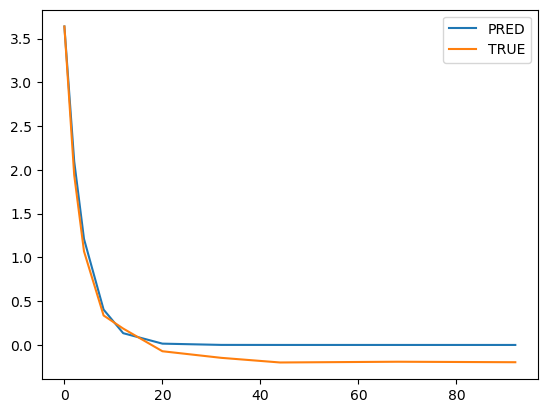

In [48]:
import matplotlib.pyplot as plt
subject_id = 50
plot_df = scale_df.loc[scale_df['SUBJID'] == 50, :]
plt.plot(predictions[50].t, predictions[50].y[0], label = 'PRED')
plt.plot(predictions[50].t, plot_df['DV'].values, label = 'TRUE')
plt.legend()